# Packages/ Imports

In [ ]:
'''
Update conda env using the following line in the /environment directory
    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `
'''

In [ ]:
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import statsmodels
import pyfolio as pf

# Import libraries for ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from src.myarima import MyARIMA
from src.init_dataset import InitDataset
from src.mykmeans import MyKMeans
import src.utils as utils
from src.mptoptimizer import MPTOptimizer
from src.myLSTM import MyLSTM
from src.dbscan import MyDBSCAN

print("Finished importing utils!")

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Data Management

In [ ]:
#Since dataset has been created, init is set to false
InitDataset.create_econ_data(init=False)
InitDataset.create_merged_stock_data(init=False)
InitDataset.create_adj_closed_price(init=False)

## Data Exploration

In [ ]:
# Load the dataset for the first ticker
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv(r'dataset/stock_data/AAPL_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
stock_data.head()

In [ ]:
# Check the shape of the dataset
print(stock_data.shape)

# Check the start and end date of the dataset
print(stock_data.index.min())
print(stock_data.index.max())

# Duration of stock data
duration = stock_data.index.max() - stock_data.index.min()
print(duration)

In [ ]:
# Data Cleaning and Sanity Check
# Check for missing values
print(stock_data.isnull().sum(), '\n')
# Check for duplicate values
print(stock_data.duplicated().sum())
# Describe the dataset
print(stock_data.describe())

# Initial Data Visualization

In [ ]:
# Plot the adjusted close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Adjusted Close Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(stock_data['Adj Close'])
plt.show()

In [ ]:
# KDE plot of the adjusted close price
plt.figure(figsize=(10,6))
sns.kdeplot(stock_data['Adj Close'], shade=True)
plt.title('KDE plot of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()

# Models

In [ ]:
# Load the dataset
test_data, train_data, index_data = InitDataset.get_test_train_data()

In [ ]:
portfolio_returns = train_data.pct_change()
covariance = portfolio_returns.cov()*252
# Heatmap of the covariance matrix
plt.figure(figsize=(10,6))
sns.heatmap(covariance, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix')
plt.show()

In [ ]:
# Allocate equal weights to all stocks

weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
portfolio_variance = np.transpose(weights) @ covariance @ weights
print(f'Portfolio Variance: {portfolio_variance}')

In [ ]:
# Calculate the portfolio volatility

windowed = portfolio_returns.rolling(30)
volatility = windowed.std() * np.sqrt(252)
volatility.plot(figsize=(10,6))
plt.title('Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [ ]:
# Plot the adjusted close price
train_data.plot(title='Adjusted Close Price')
plt.show()

In [ ]:
# Calculate the daily returns
asset_returns = train_data.pct_change()
portfolio_returns = asset_returns@weights

# Plot the daily returns
portfolio_returns.plot().set_ylabel('Daily Returns')
plt.title('Portfolio Daily Returns')
plt.show()

In [ ]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed= portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

In [ ]:
# Convert daily returns to quarterly average returns
quarterly_returns = portfolio_returns.resample('MS').mean().dropna()
quarterly_returns.plot().set_ylabel("Quarterly Returns")
plt.title('Portfolio Quarterly Returns')
plt.show()

In [ ]:
# Transform daily portfolio_returns returns into quarterly minimum returns
quarterly_min_returns = portfolio_returns.resample('Q').min().dropna()
quarterly_min_returns.plot().set_ylabel("Quarterly Minimum Returns")
plt.title('Portfolio Quarterly Minimum Returns')
plt.show()

## Kmeans - Volatility (Daily)

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.volatility_feature_engineering()

cluster_range = range(3, 10)
kmeans.volatility_clustering_without_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_without_pca()
kmeans.volatility_clustering_with_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_pca()

kmeans.plot_metrics()

## Kmeans - Quarterly data


In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.gdp_quarterly_feature_engineering()

kmeans.gdp_quarterly_clustering_without_pca()
kmeans.gdp_quarterly_clustering_pca()


## Kmeans Balance dataset

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.quarterly_feature_engineering(n_clusters=4)

## Kmeans - Economic data 

In [ ]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_econ_data()
indicators = ['REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'PSAVERT', 'UNRATE']
kmeans.economic_indicator_clustering_without_pca(indictors=indicators)
kmeans.economic_indicator_clustering_pca(indictors=indicators)

## DBSCAN

In [ ]:
dbscan = MyDBSCAN()
dbscan.set_stock_data()
dbscan.volatility_feature_engineering()
dbscan.get_elbow_plot()
dbscan.volatility_clustering_without_pca()
dbscan.get_nearest_neighbors()
dbscan.get_elbow_plot()
dbscan.volatility_clustering_with_pca()

In [ ]:
dbscan.clustering_with_quarterly_returns()

# ARMIA visualizations

In [ ]:
# Check for stationarity using the Augmented Dickey-Fuller test
models = []
for col in train_data.columns:
    print(col)
    adj_closed = train_data[col]
    # columns_except_first = stock_data.iloc[:, 1:]
    arima = MyARIMA(adj_closed)
    models.append((arima,col))
    arima.check_stationarity(adj_closed)

Looking at the Rolling Mean and Original Data, We are deciding whether the time series can be captured by a normal time series or 
it needs to be converted to logarithm

In [ ]:
convert_log = {'AAPL' : True,'AMD' : True,'AMZN': False,'F': True,'GOOG' : False,'INTC':False,'JPM':False,'MSFT':False, 'MS': True,
               'NVDA':True, 'TSLA':True,'VOO':False}

The plot depicts increasing mean and standard deviation. Additionally p-value > 0.05. Hence, the timeseries is not stationary.

Additionally, the test statistics exceeds the critical values. As a result, the data is nonlinear.

### Make the time-series stationary

### ACF and PACF plots 

In [ ]:
shift = 1
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    diff_data = arima.difference_data(data,shift)[1:]
    arima.check_stationarity(diff_data)
    arima.acf_pacf_plots(diff_data)

All p-values are well below the threshold, so we can consider the difference time series to be stationary. So the degree d of ARIMA(p,d,q) for all stocks is 1.

For p and q values, we will use the auto arima function to get the parameters for the ARIMA model

In [ ]:
forecasted_data = test_data.copy()
N = len(forecasted_data)
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    arima.fit_arima_parameters(data)
    if convert_log[col]:
        forecasted_data[col] = np.exp(arima.forecast(data,N))
    else:
        forecasted_data[col] = arima.forecast(data,N)


In [ ]:
mpt = MPTOptimizer()
l = list(test_data.columns)

In [ ]:
arima_allocs = mpt.optimize_portfolio(forecasted_data)
print("Forecasted Data Allocation")
for val, ticker in zip(arima_allocs, l):
    print(ticker + ": " + str(round(val,3)))

In [ ]:
mpt_allocs = mpt.optimize_portfolio(train_data)
print("MyOptimizer's Data Allocation")
for val, ticker in zip(mpt_allocs, l):
    print(ticker + ": " + str(round(val,3)))

In [ ]:
mean_arima, std_arima, cr_arima, sr_arima = utils.sharpe_ratio_metrics(test_data,arima_allocs)
treynor_arima,beta_arima,alpha_arima = utils.treynor_ratio_metrics(test_data,arima_allocs,index_data)
print("ARIMA Metrics")
print("Mean: " + str(mean_arima))
print("Std Dev: " + str(std_arima))
print("Calculated Risk: " + str(cr_arima))
print("Sharpe Ratio: " + str(sr_arima))
print("Treynor Ratio: " + str(treynor_arima))
print("Beta: " + str(beta_arima))
print("Alpha: " + str(alpha_arima))

In [ ]:
mean_mpt, std_mpt,cr_mpt, sr_mpt = utils.sharpe_ratio_metrics(test_data,mpt_allocs)
treynor_mpt,beta_mpt,alpha_mpt = utils.treynor_ratio_metrics(test_data,mpt_allocs,index_data)
print("MyOptimizer Metrics")
print("Mean: " + str(mean_mpt))
print("Std Dev: " + str(std_mpt))
print("Calculated Risk: " + str(cr_mpt))
print("Sharpe Ratio: " + str(sr_mpt))
print("Treynor Ratio: " + str(treynor_mpt))
print("Beta: " + str(beta_mpt))
print("Alpha: " + str(alpha_mpt))



In [ ]:
kmeans_allocs = [0,0,0,0,0,0,1.0/3,0,0,1.0/3,0,1.0/3]

In [ ]:
mean_kmeans, std_kmeans,cr_kmeans, sr_kmeans = utils.sharpe_ratio_metrics(test_data,kmeans_allocs)
treynor_kmeans,beta_kmeans,alpha_kmeans = utils.treynor_ratio_metrics(test_data,kmeans_allocs,index_data)

print("KMeans Metrics")
print("Mean: " + str(mean_kmeans))
print("Std Dev: " + str(std_kmeans))
print("Calculated Risk: " + str(cr_kmeans))
print("Sharpe Ratio: " + str(sr_kmeans))
print("Treynor Ratio: " + str(treynor_kmeans))
print("Beta: " + str(beta_kmeans))
print("Alpha: " + str(alpha_kmeans))


In [ ]:
kmeans_pca_allocs = [0,0,0,0,0,0,1.0/4,0,0,1.0/4,1.0/4,1.0/4]

In [ ]:
mean_kmeans_pca, std_kmeans_pca,cr_kmeans_pca, sr_kmeans_pca = utils.sharpe_ratio_metrics(test_data,kmeans_pca_allocs)
treynor_kmeans_pca,beta_kmeans_pca,alpha_kmeans_pca = utils.treynor_ratio_metrics(test_data,kmeans_pca_allocs,index_data)


print("KMeans w PCA Metrics")
print("Mean: " + str(mean_kmeans_pca))
print("Std Dev: " + str(std_kmeans_pca))
print("Calculated Risk: " + str(cr_kmeans_pca))
print("Sharpe Ratio: " + str(sr_kmeans_pca))
print("Treynor Ratio: " + str(treynor_kmeans_pca))
print("Beta: " + str(beta_kmeans_pca))
print("Alpha: " + str(alpha_kmeans_pca))

# LSTM for portfolio allocation

In [15]:
seq_len = 100
num_epochs = 5000
# Fit all tickers and get models, loss tracks, and predictions
models, all_loss_tracks, scalar = MyLSTM.fit_all_tickers(train_data, test_data, seq_len, num_epochs)


--------------------------------------------------
Fitting model for ticker: AMD
--------------------------------------------------
Epoch 0/5000, Loss=0.36856386065483093
Epoch 100/5000, Loss=0.24944527447223663
Epoch 200/5000, Loss=0.17472290992736816
Epoch 300/5000, Loss=0.12590749561786652
Epoch 400/5000, Loss=0.0946078971028328
Epoch 500/5000, Loss=0.07539227604866028
Epoch 600/5000, Loss=0.06423011422157288
Epoch 700/5000, Loss=0.05811699107289314
Epoch 800/5000, Loss=0.05492492392659187
Epoch 900/5000, Loss=0.05325009673833847
Epoch 1000/5000, Loss=0.05221577361226082
Epoch 1100/5000, Loss=0.05123215541243553
Epoch 1200/5000, Loss=0.049627602100372314
Epoch 1300/5000, Loss=0.04537287726998329
Epoch 1400/5000, Loss=0.028741227462887764
Epoch 1500/5000, Loss=0.011178605258464813
Epoch 1600/5000, Loss=0.007153632119297981
Epoch 1700/5000, Loss=0.005104159936308861
Epoch 1800/5000, Loss=0.003932139836251736
Epoch 1900/5000, Loss=0.0031236419454216957
Epoch 2000/5000, Loss=0.002519674

Evaluating model for ticker: AMD


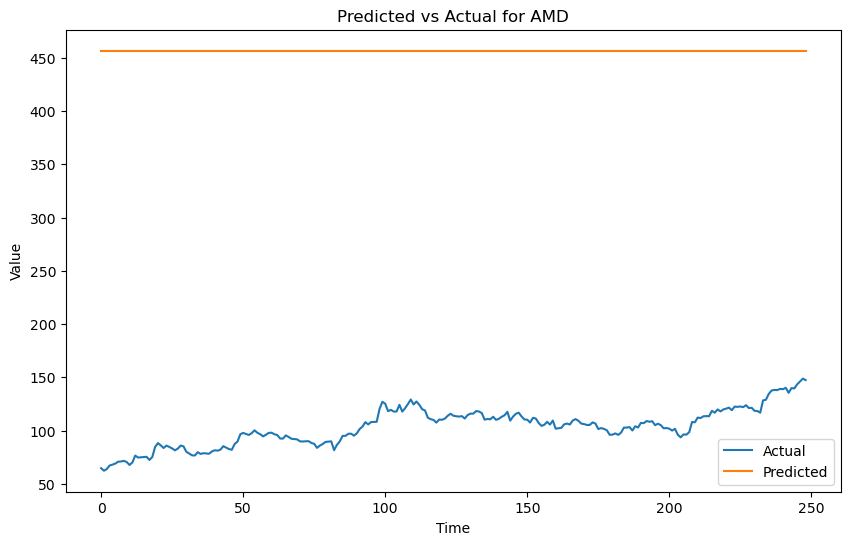

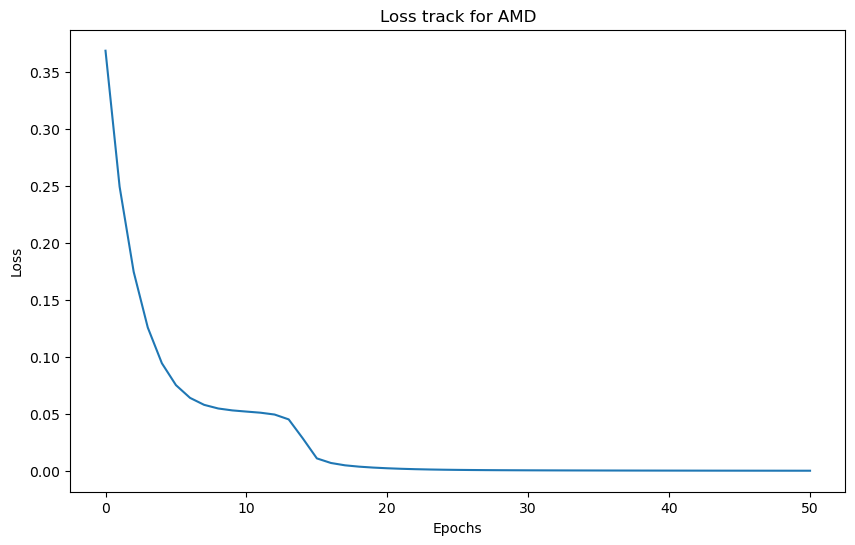

Evaluating model for ticker: AMZN


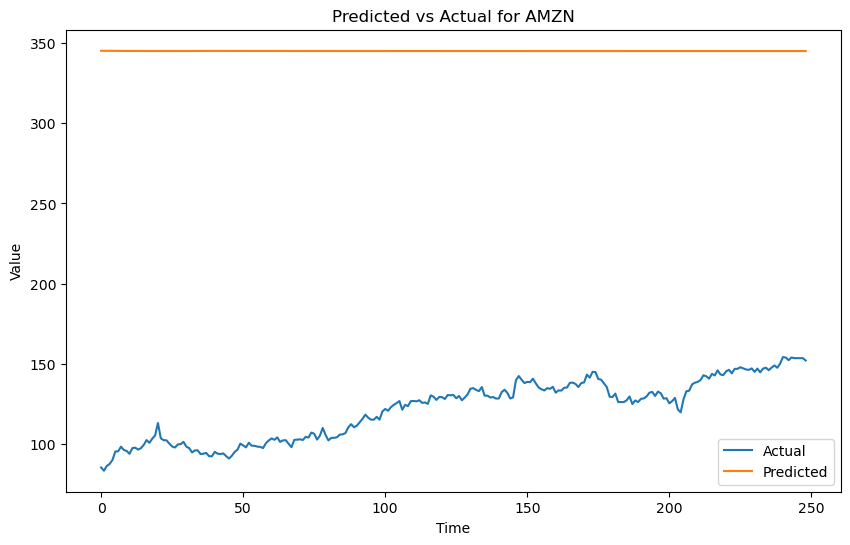

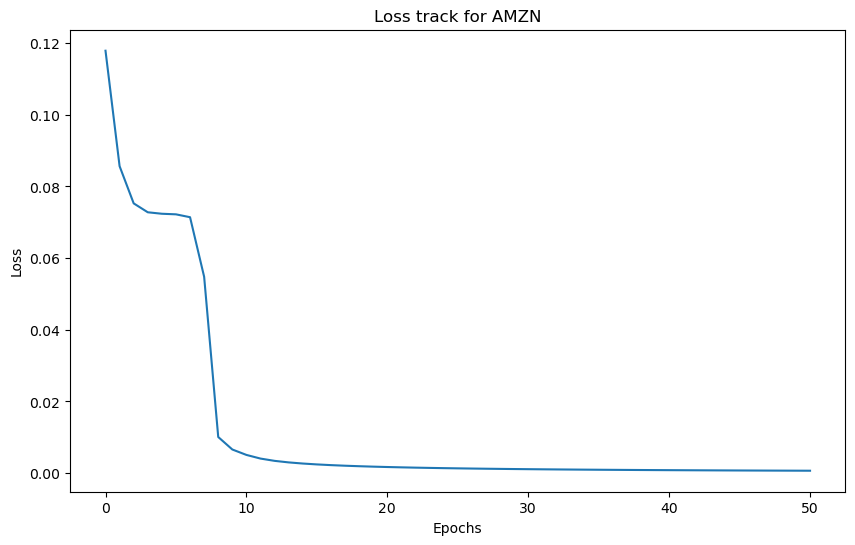

Evaluating model for ticker: F


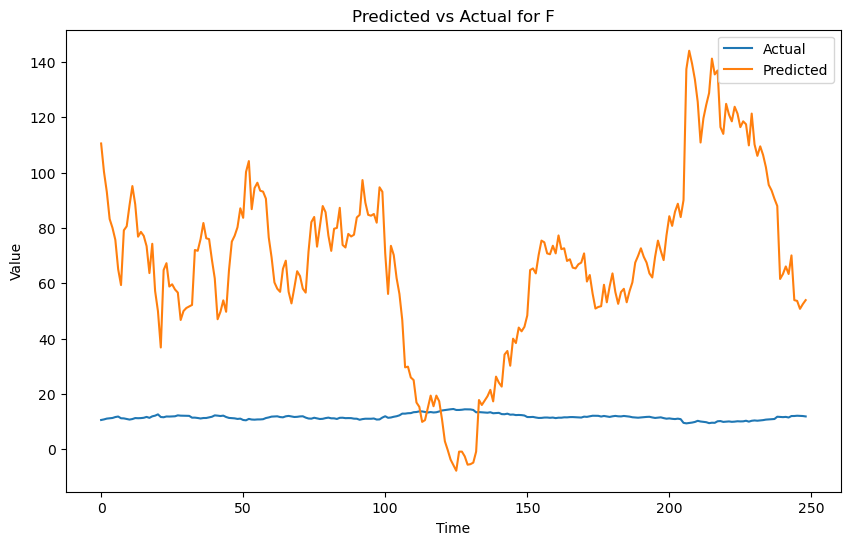

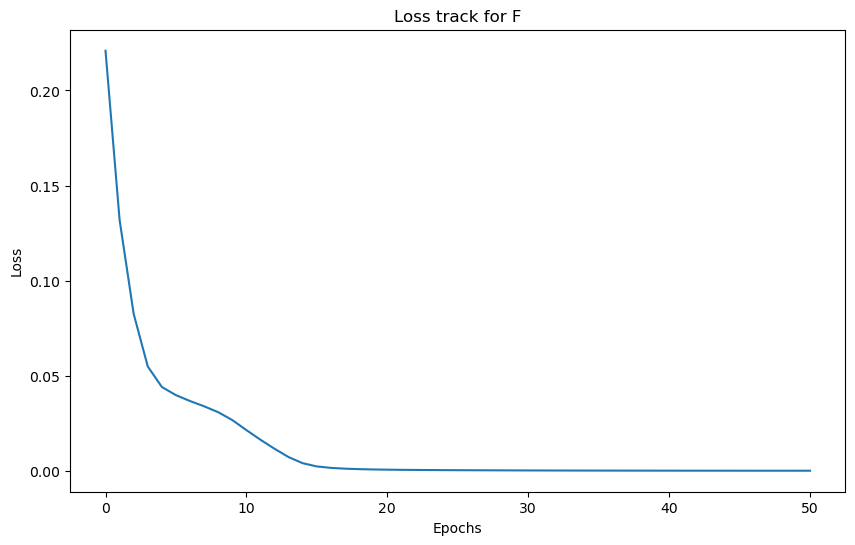

Evaluating model for ticker: GOOG


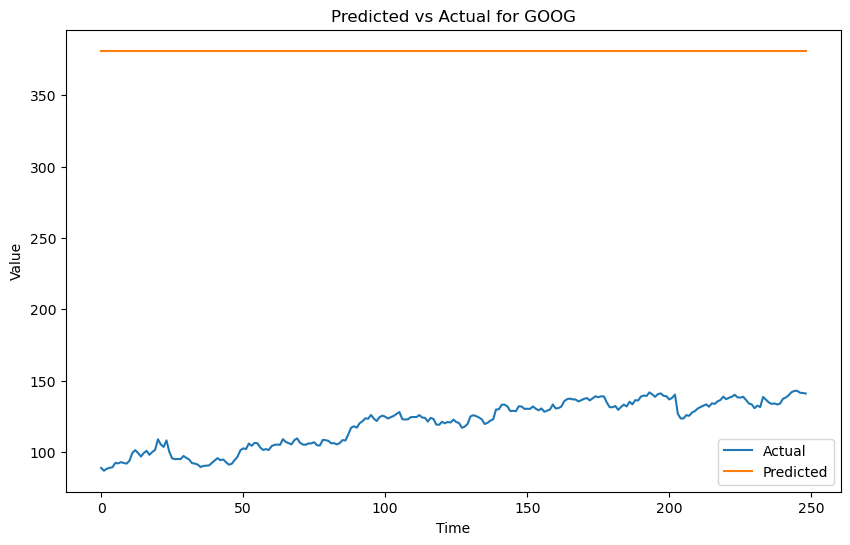

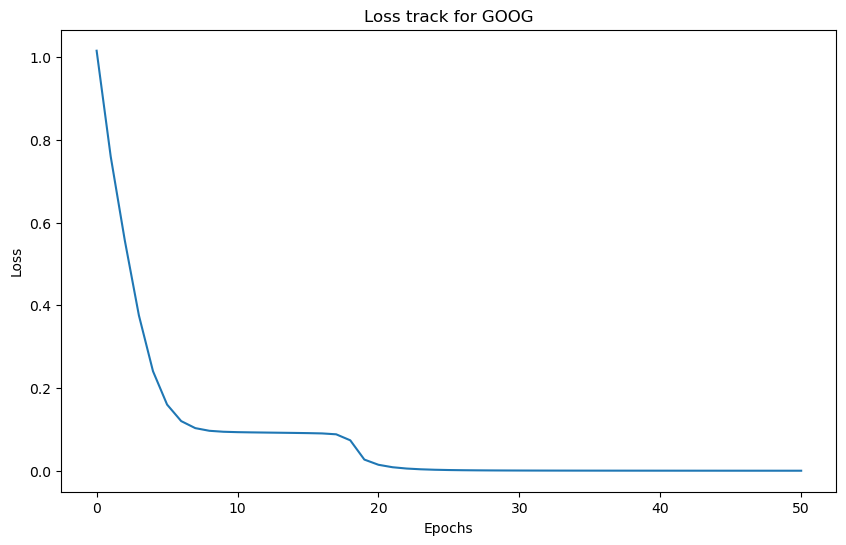

Evaluating model for ticker: INTC


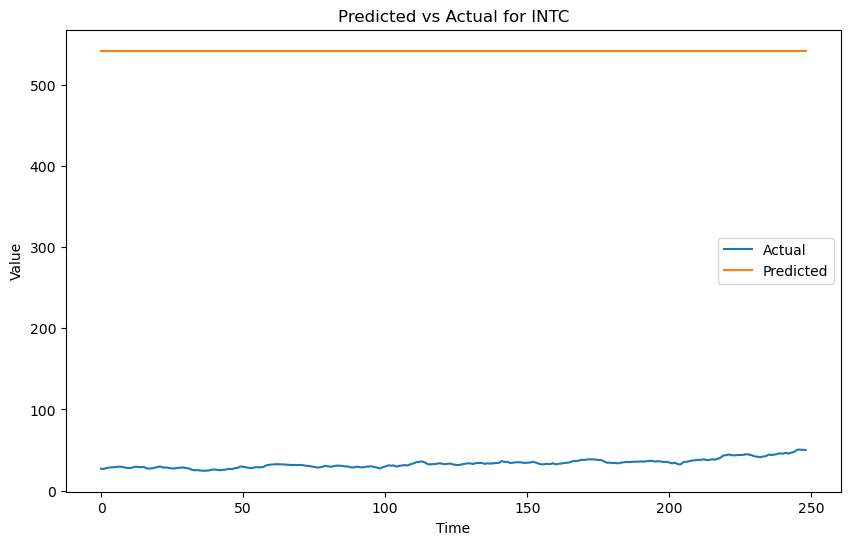

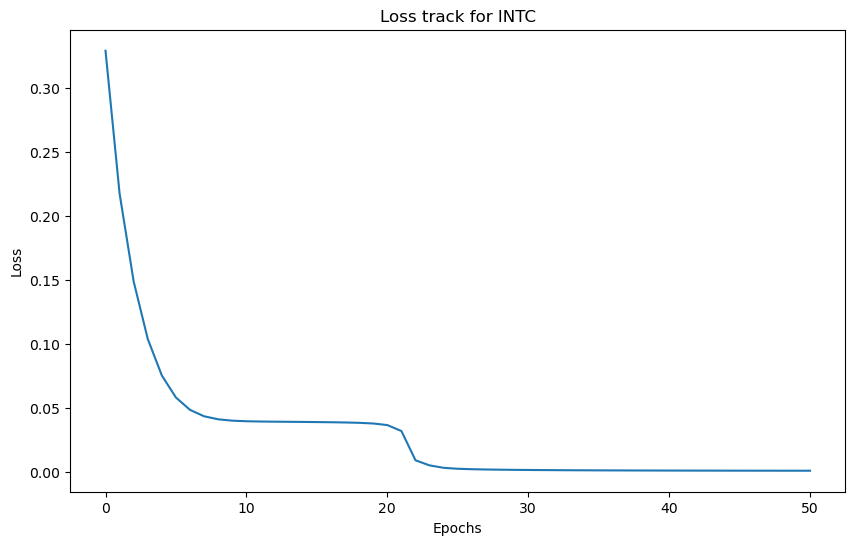

Evaluating model for ticker: JPM


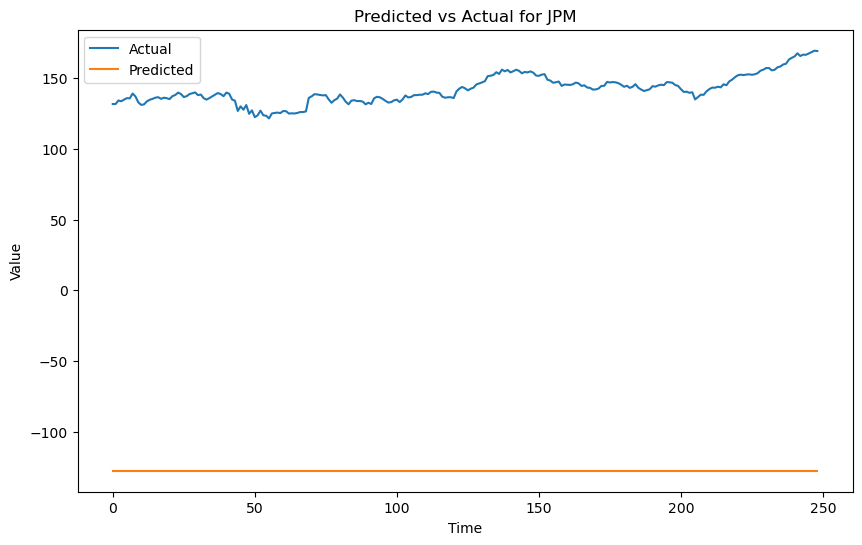

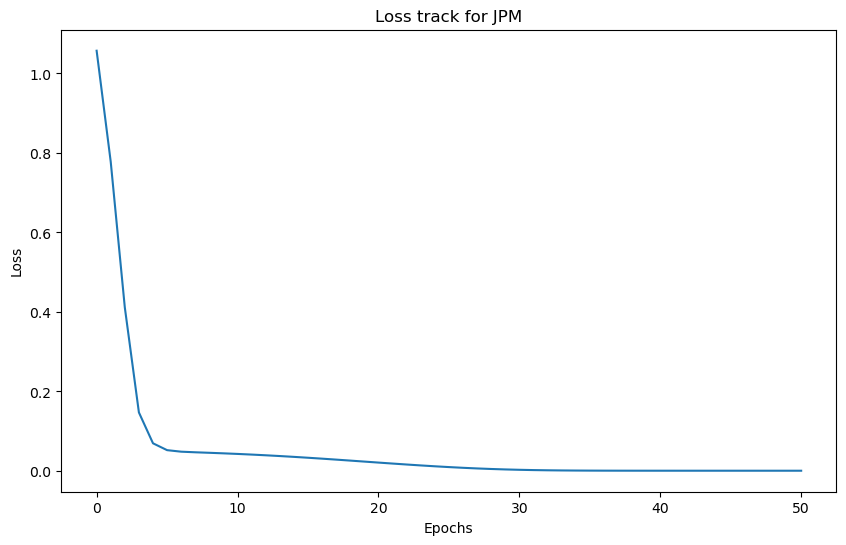

Evaluating model for ticker: MSFT


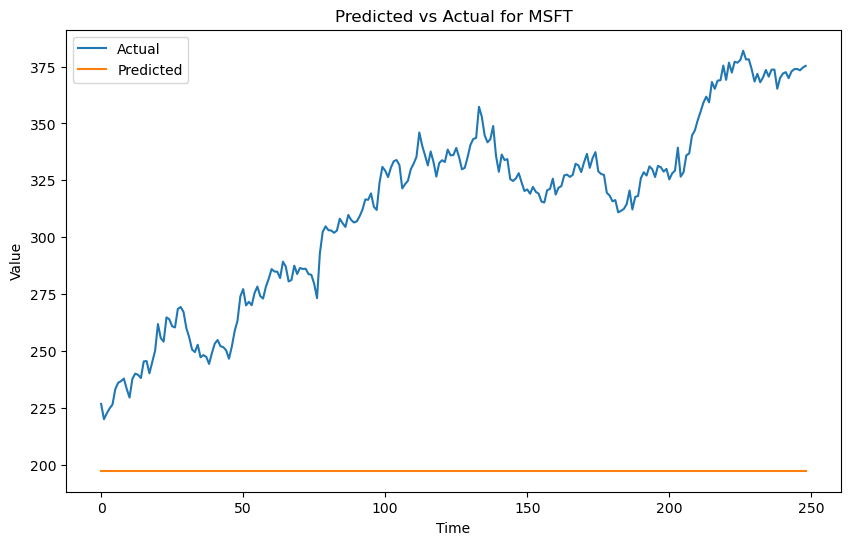

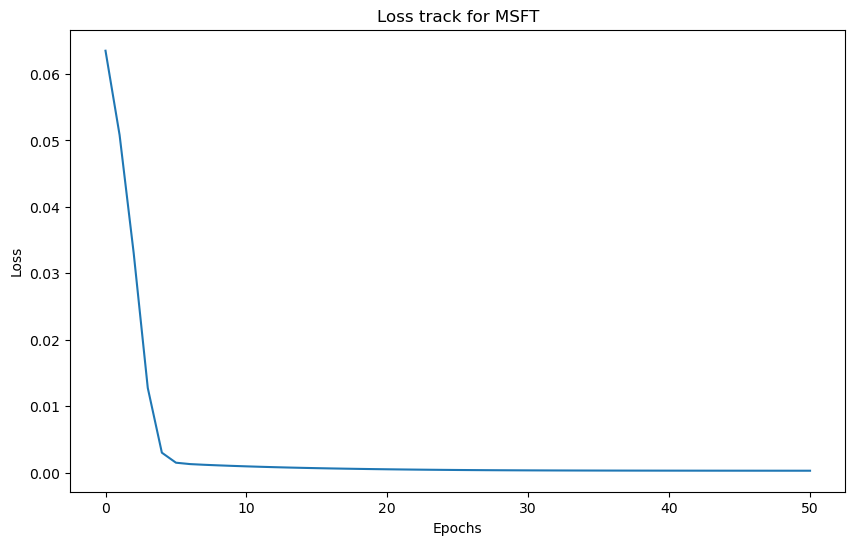

Evaluating model for ticker: MS


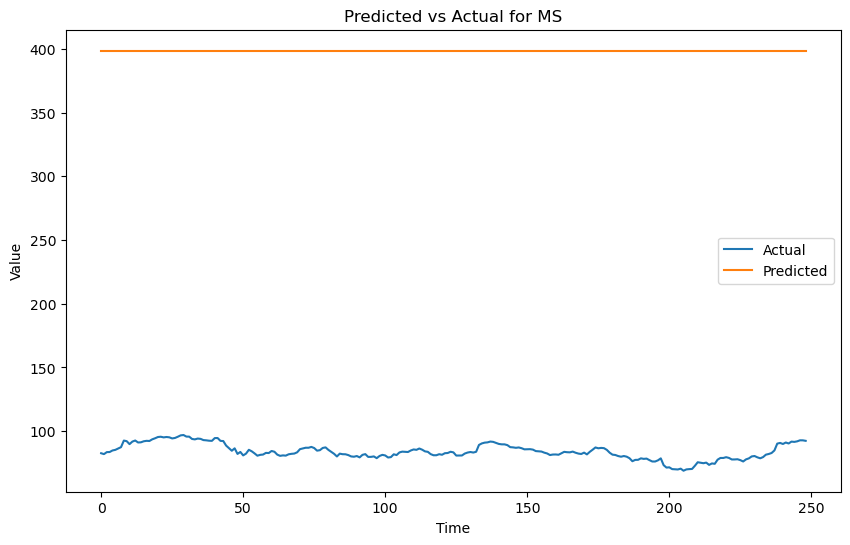

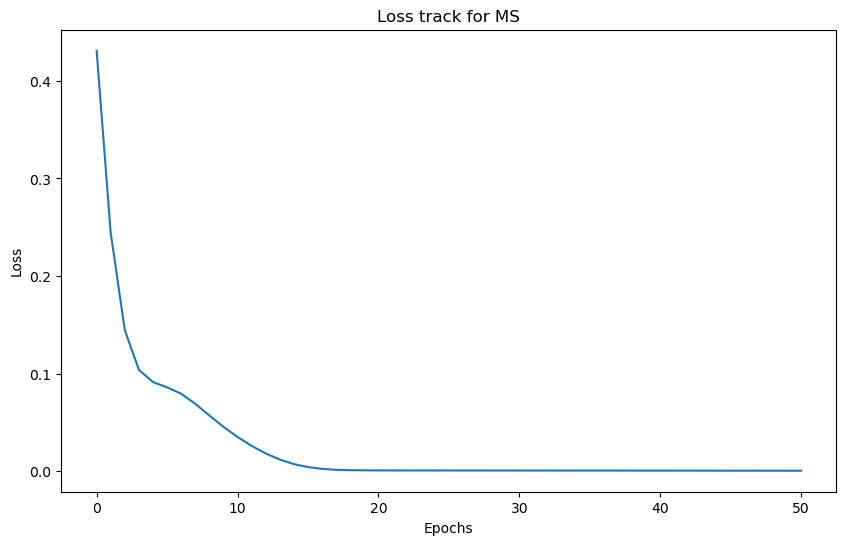

Evaluating model for ticker: NVDA


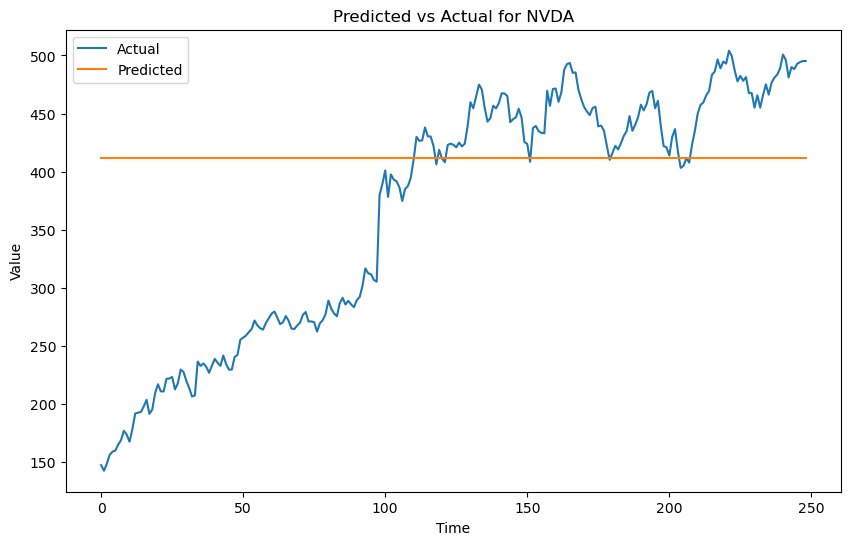

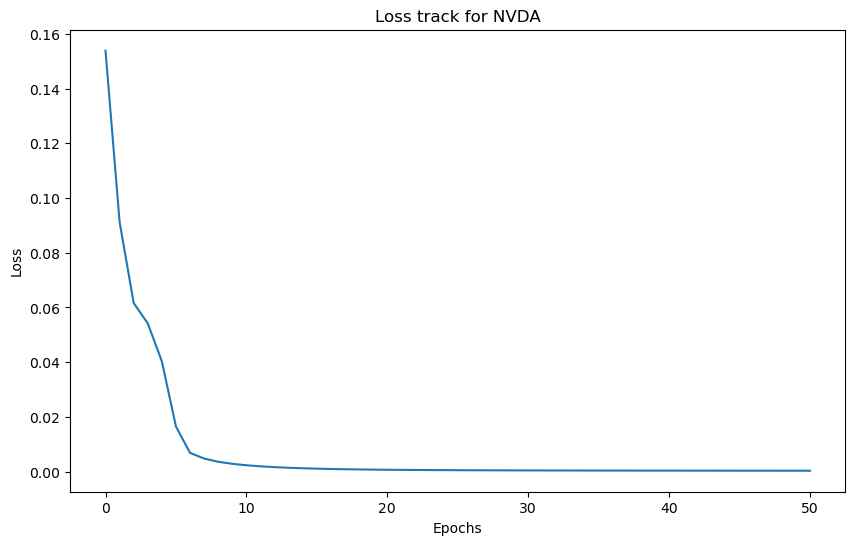

Evaluating model for ticker: TSLA


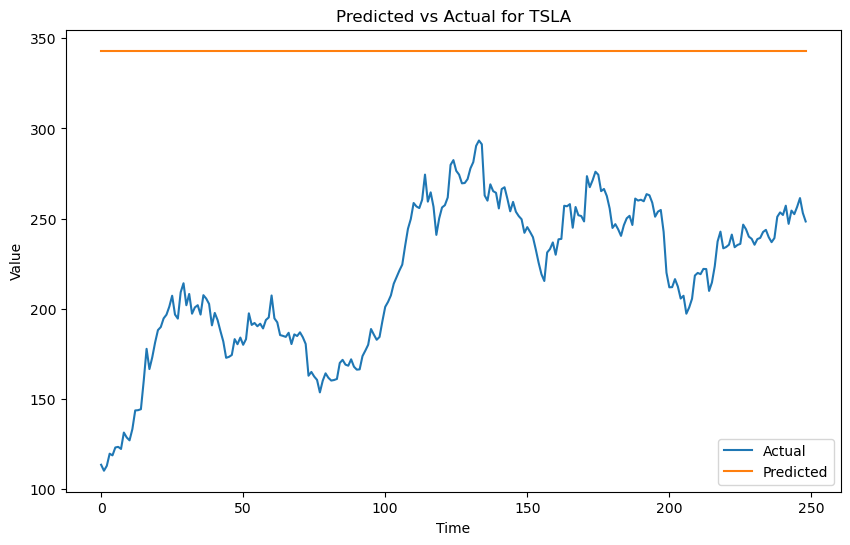

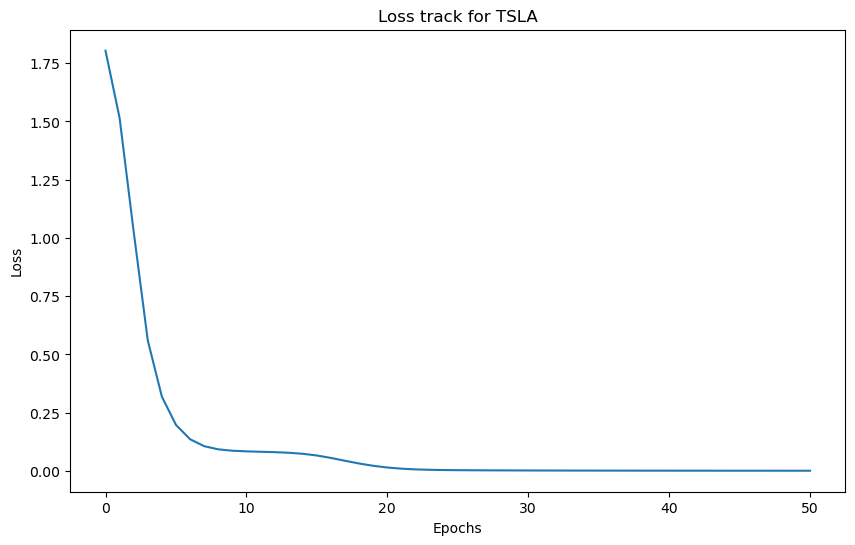

Evaluating model for ticker: VOO


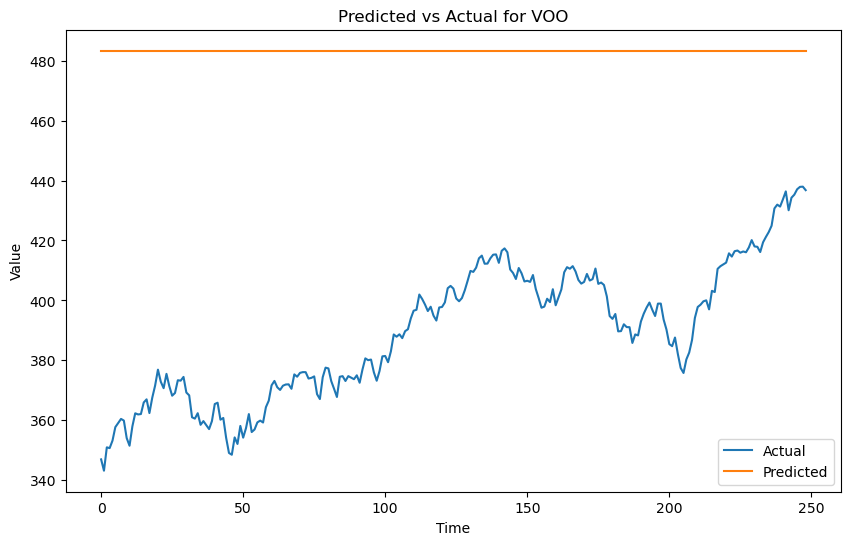

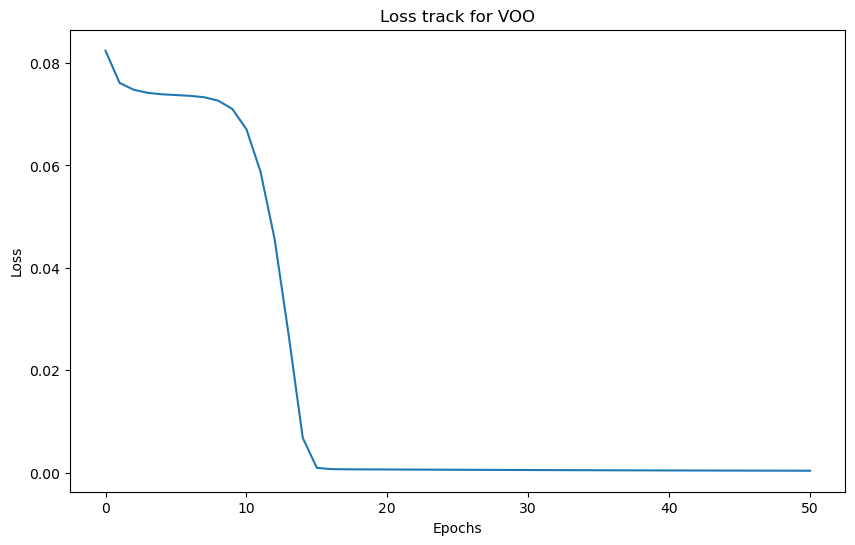

In [16]:
# Test the models
predicted_df, loss_df = MyLSTM.test(models, test_data, all_loss_tracks, scalar)